In [28]:
#import Pkg; Pkg.add("BenchmarkTools")

In [29]:
using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1273


In [4]:
#import Pkg; Pkg.add("CSV")
#Pkg.add("Plots")
#Pkg.add("PyPlot")

In [30]:
using Plots

In [31]:
using CSV

In [32]:
""" Linear interpolation
"""
function build_interp1d(x, y)
    function interp1d_glob(t)
        idx = searchsortedfirst(x, t)
        if idx <= 1
            return y[1]
        elseif idx == length(x)+1
            return y[end]
        else
            prev = idx-1
            slope = (y[idx] - y[prev])/(x[idx] - x[prev])
            return y[prev] + slope*(t - x[prev])
        end
    end
    return interp1d_glob
end

build_interp1d

In [33]:
path = "../data/Fichiers_Meteo_RT2012/H1a_Trappes.csv"
data = CSV.read(path; header=1);

println(names(data))

Symbol[Symbol("# Htsmd"), :te0, :dirN]


In [34]:
# Define interpolation function for weather data
seconds_values = Array(data[!, 1]) * 60.0*60.0;
Text_values = Array(data[!, 2]);
directSun_values = Array(data[!, 3]);

T_ext = build_interp1d(seconds_values, Text_values)
solar_irrad = build_interp1d(seconds_values, directSun_values)

(::var"#interp1d_glob#4"{Array{Float64,1},Array{Float64,1}}) (generic function with 1 method)

In [36]:
include("SimuThermiqueSolver_src.jl")
using .SimuThermiqueSolver

In [38]:
minute = 60.0
hour = 60.0 * minute
day = 24 * hour

86400.0

In [111]:
m = Model(dt=10minute)

L = 3.0  # house size, meter

air = Material(25e-3, 1.225, 1.0006)
clay = Material(1.28, 880.0, 1450.0) # Clay
roof_isolation = Material(0.036, 150.0, 2700.2)
slab_isolation = Material(0.036, 150.0, 2700.2)
wall_isolation = Material(0.036, 150.0, 2700.2)

interior_air = add_simplethermalmass!(m, "air"; thermal_mass=air.rho*air.Cp*L^2)
roof = add_simple_wall!(m, "roof", material=roof_isolation, thickness=.10, area=1.2*L)
slab = add_composite_wall!(m, "slab", layers=[(slab_isolation, 0.1), (clay, 1.5*L)], area=1.0*L)
south_wall = add_simple_wall!(m, "souht_wall", material=wall_isolation, thickness=0.10, area=L*0.5)

h_exterior = 6.5
h_interior_vertical = .7
h_interior_horizontal = 2.5


add_convectivesource!(m, roof.ext; Tsource=T_ext, hS=h_exterior*L)
add_convectivesource!(m, south_wall.ext; Tsource=T_ext, hS=h_exterior*L)

add_conductance!(m, roof.int, interior_air; UA=h_interior_vertical*L/2)
add_conductance!(m, south_wall.int, interior_air; UA=h_interior_vertical*L/2)
add_conductance!(m, slab.int, interior_air; UA=h_interior_horizontal*L)

add_convectivesource!(m, slab.ext; Tsource=t->14, hS=10*h_exterior)

add_directsource!(m, roof.ext, flux=t->0.8*solar_irrad(t)*L)
add_directsource!(m, south_wall.ext, flux=t->0.4*solar_irrad(t)*L/2.0)

In [119]:
save = [roof.int, slab.int, interior_air];
save_idx = map(x->m.id_to_index[x], save);

In [123]:
state = init_solver(m);

# Burn (solve in reverse)
state.dt = -state.dt
state.t = 15day

n_iter = Int(floor(state.t/m.dt));

for k in 1:n_iter
    iter!(state)
end

state.dt = -state.dt

600.0

In [124]:
# solve
n_iter = Int(floor(150day/m.dt));

sol = zeros(n_iter, length(save_idx))
times = zeros(n_iter)
for k in 1:n_iter
    iter!(state)
    sol[k, :] = state.T[save_idx]
    times[k] = state.t
end

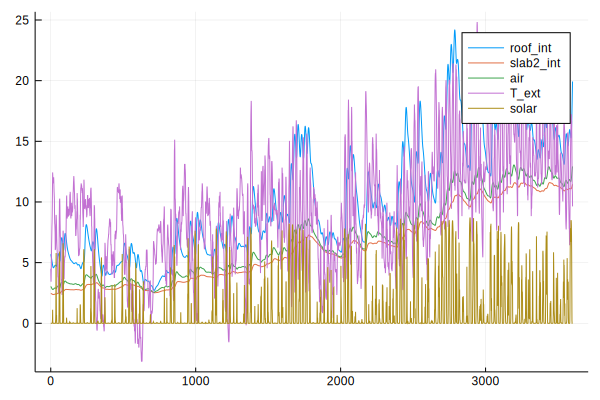

In [125]:
plot(times/hour, sol, label=permutedims(save))
plot!(times/hour, [T_ext(t) for t in times], label="T_ext")
plot!(times/hour, [0.01*solar_irrad(t) for t in times], label="solar")

MetaModel

same as model but takes Params instead of values

